C:\Users\ryanu\AppData\Local\Temp\ipykernel_4720\2601168529.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(save_path, map_location=device

Test Loss = 0.4028
Test Exact Match Accuracy (Accuracy All/Match) = 0.0061
Test At Least One Match = 0.7044
Test Hamming Loss = 0.2552
Test Accuracy (Label-Based) = 0.7448

Genre      Recall Precision F1  Count
Action     0.83  0.17    0.29  240
Adventure  0.55  0.11    0.18  115
Animation  0.46  0.19    0.27  85
Aniplex    0.00  0.00    0.00  0
BROSTA TV  0.00  0.00    0.00  0
Carousel Productions 0.00  0.00    0.00  0
Comedy     0.34  0.56    0.43  534
Crime      0.70  0.13    0.23  172
Documentary 0.66  0.10    0.17  139
Drama      0.38  0.58    0.46  816
Family     0.41  0.20    0.27  111
Fantasy    0.48  0.11    0.18  89
Foreign    0.69  0.06    0.10  72
GoHands    0.00  0.00    0.00  0
History    0.60  0.05    0.09  72
Horror     0.92  0.15    0.26  172
Mardock Scramble Production Committee 0.00  0.00    0.00  0
Music      0.21  0.04    0.07  58
Mystery    0.85  0.08    0.14  94
Odyssey Media 0.00  0.00    0.00  0
Pulser Productions 0.00  0.00    0.00  0
Rogue State 0.00  0.00   

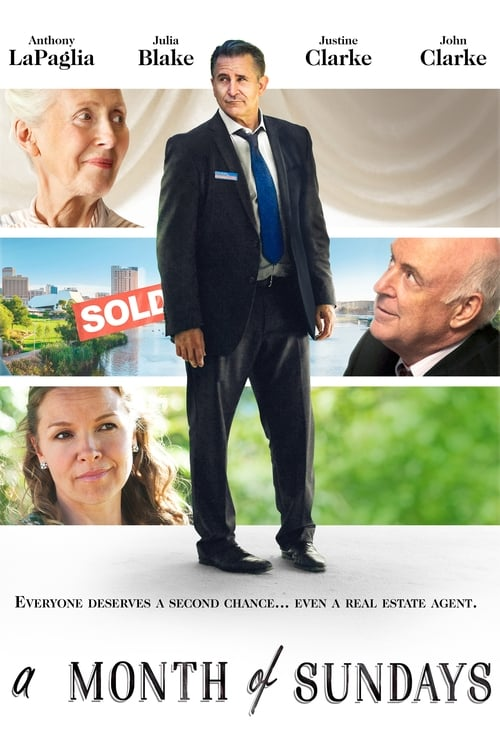

Predicted: Comedy-Drama
True: Comedy-Drama

Saved correct example at: saved_examples\correct_144784_pred_Comedy-Drama-Romance_true_Comedy-Drama-Romance.png


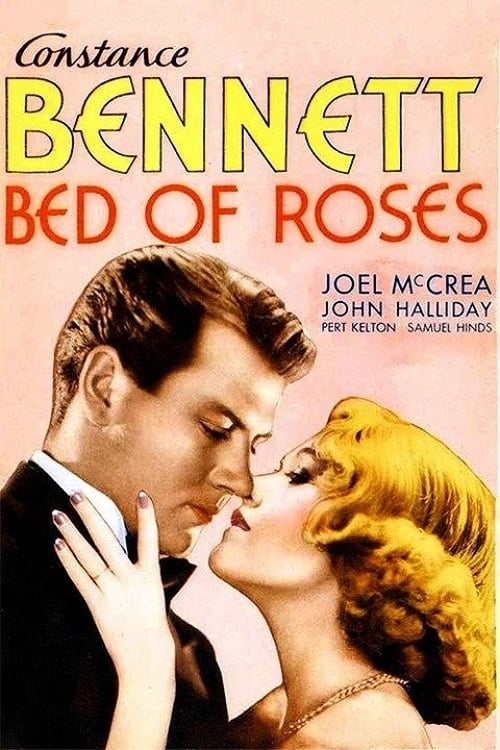

Predicted: Comedy-Drama-Romance
True: Comedy-Drama-Romance

Saved incorrect example at: saved_examples\incorrect_401359_pred_Action-Crime-Documentary-Foreign-History-Horror-Mystery-Science Fiction-Thriller-War_true_Drama-Horror-Thriller.png


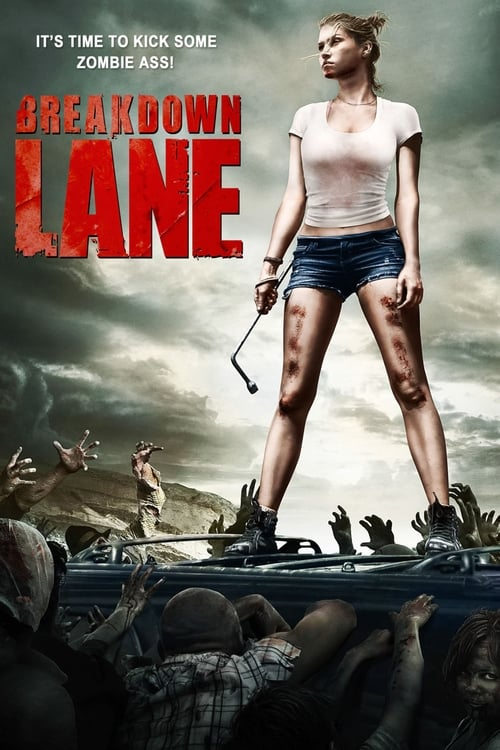

Predicted: Action-Crime-Documentary-Foreign-History-Horror-Mystery-Science Fiction-Thriller-War
True: Drama-Horror-Thriller

Saved incorrect example at: saved_examples\incorrect_257343_pred_Action-Adventure-Fantasy-Horror-Science Fiction-TV Movie-War_true_Comedy.png


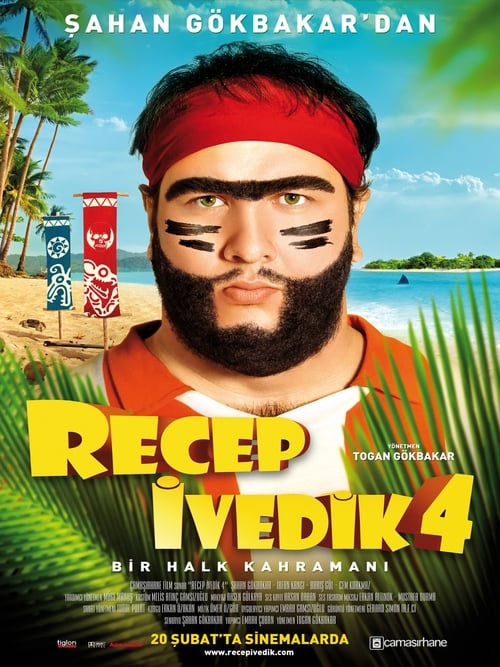

Predicted: Action-Adventure-Fantasy-Horror-Science Fiction-TV Movie-War
True: Comedy



In [1]:
import sys
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image as PILImage
from IPython.display import display, Image as IPyImage

# Add the project root to the Python path
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.append(PROJECT_ROOT)

from src.models.model import MovieClassifier  # Import your model definition
from src.data.movie_dataset import MovieDataset, get_genre_list  # Import your dataset code

def main():
    # Paths to your CSV splits and processed posters
    test_csv  = r"C:\Users\ryanu\Desktop\Newfolder\dataset\training_testing\test.csv"
    processed_folder = r"C:\Users\ryanu\Desktop\Newfolder\dataset\filtered_dataset\processed_posters"
    metadata_path = r"C:\Users\ryanu\Desktop\Newfolder\dataset\filtered_dataset\filtered_movies_metadata.csv"  
    save_path = r"C:\Users\ryanu\Desktop\Newfolder\model_checkpoint\model_epoch_20.pth"

    # Directory to save example images
    save_examples_dir = "saved_examples"
    os.makedirs(save_examples_dir, exist_ok=True)

    # Get genre list
    genre_list = get_genre_list(metadata_path)
    num_genres = len(genre_list)

    # Create test dataset & DataLoader
    # IMPORTANT: Ensure that MovieDataset returns (img, target, movie_id) in __getitem__
    test_dataset = MovieDataset(csv_path=test_csv, processed_folder=processed_folder, genre_list=genre_list, return_id=True)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MovieClassifier(backbone="resnet18", num_genres=num_genres).to(device)

    model_state_dict = torch.load(save_path, map_location=device)  
    model.load_state_dict(model_state_dict)

    criterion = nn.BCEWithLogitsLoss()

    model.eval()
    test_loss = 0.0

    all_targets = []
    all_preds = []

    # We'll keep track of the IDs, so we can map back after predictions
    movie_ids_list = []

    # To store indices of correct and incorrect predictions
    correct_indices = []
    incorrect_indices = []

    needed_correct = 2
    needed_incorrect = 2

    # Run inference on test set
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating on Test Set")):
            images, targets, movie_ids = batch
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            loss = criterion(logits, targets)
            test_loss += loss.item()

            # Convert logits to probabilities
            probs = torch.sigmoid(logits)
            # Convert probabilities to binary predictions (threshold=0.5)
            preds = (probs > 0.5).float()

            all_targets.append(targets.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            movie_ids_list.extend(movie_ids)

            # Determine correctness: exact match per sample
            correct_per_sample = torch.all(preds == targets, dim=1).cpu().numpy()

            # Check if we still need correct/incorrect samples
            if (needed_correct > 0) or (needed_incorrect > 0):
                batch_size = images.size(0)
                for i in range(batch_size):
                    if correct_per_sample[i] and needed_correct > 0:
                        correct_indices.append((batch_idx, i))
                        needed_correct -= 1
                    elif not correct_per_sample[i] and needed_incorrect > 0:
                        incorrect_indices.append((batch_idx, i))
                        needed_incorrect -= 1

                    if needed_correct == 0 and needed_incorrect == 0:
                        # We have what we need
                        break

            # If we have found all needed samples, just continue to gather full metrics.

    avg_test_loss = test_loss / len(test_loader)
    all_targets = np.concatenate(all_targets, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    # Exact Match Accuracy: fraction of samples perfectly predicted
    exact_match_acc = (all_targets == all_preds).all(axis=1).mean()

    # At least one match accuracy: fraction of samples with at least one correct label
    at_least_one_match = ((all_targets * all_preds).sum(axis=1) > 0).mean()

    # Hamming loss: fraction of individual label errors
    h_loss = hamming_loss(all_targets, all_preds)

    # Label-based accuracy (test accuracy):
    test_acc = accuracy_score(all_targets.flatten(), all_preds.flatten())

    print(f"Test Loss = {avg_test_loss:.4f}")
    print(f"Test Exact Match Accuracy (Accuracy All/Match) = {exact_match_acc:.4f}")
    print(f"Test At Least One Match = {at_least_one_match:.4f}")
    print(f"Test Hamming Loss = {h_loss:.4f}")
    print(f"Test Accuracy (Label-Based) = {test_acc:.4f}")

    # Compute per-genre metrics
    genre_precision = precision_score(all_targets, all_preds, average=None, zero_division=0)
    genre_recall = recall_score(all_targets, all_preds, average=None, zero_division=0)
    genre_f1 = f1_score(all_targets, all_preds, average=None, zero_division=0)
    genre_counts = all_targets.sum(axis=0)

    print("\nGenre      Recall Precision F1  Count")
    for i, genre in enumerate(genre_list):
        print(f"{genre:<10s} {genre_recall[i]:.2f}  {genre_precision[i]:.2f}    {genre_f1[i]:.2f}  {int(genre_counts[i])}")

    # --- Save and display the selected correct and incorrect examples ---
    def save_and_display_example(index_tuple, is_correct):
        batch_idx, i_in_batch = index_tuple
        global_idx = batch_idx * test_loader.batch_size + i_in_batch

        # Retrieve movie_id
        movie_id = movie_ids_list[global_idx]
        image_path = os.path.join(r"C:\Users\ryanu\Desktop\Newfolder\dataset\filtered_dataset\posters", f"{movie_id}.jpg")

        # Load the original image
        pil_img = PILImage.open(image_path).convert("RGB")

        # Retrieve predicted and true labels
        pred_labels = all_preds[global_idx]
        true_labels = all_targets[global_idx]

        # Get genre names for predicted and true labels
        pred_genre_str = "-".join([genre_list[j] for j, val in enumerate(pred_labels) if val == 1]) or "none"
        true_genre_str = "-".join([genre_list[j] for j, val in enumerate(true_labels) if val == 1]) or "none"

        # Filename
        status = "correct" if is_correct else "incorrect"
        filename = f"{status}_{movie_id}_pred_{pred_genre_str}_true_{true_genre_str}.png"
        filepath = os.path.join(save_examples_dir, filename)
        pil_img.save(filepath)
        print(f"Saved {status} example at: {filepath}")

        # Display inline in Jupyter
        display(IPyImage(filename=filepath))
        print(f"Predicted: {pred_genre_str}")
        print(f"True: {true_genre_str}\n")

    # Display correct examples
    for idx_tuple in correct_indices:
        save_and_display_example(idx_tuple, is_correct=True)

    # Display incorrect examples
    for idx_tuple in incorrect_indices:
        save_and_display_example(idx_tuple, is_correct=False)

# Call main directly (in a notebook cell)
main()
